In [1]:
from category_encoders import BinaryEncoder
# Data manipulation
# --------------------------------------------------------
import pandas as pd
import numpy as np
import polars as pl
import math
import time
from sklearn.cluster import HDBSCAN
import joblib
# Visualizations
# --------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
#import altair as alt
#from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
#from bokeh.plotting import figure, show
import seaborn.objects as so
import plotly.express as px

from sklearn.metrics import silhouette_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Custom scripts
# ---------------------------------------------------------
from scripts.data_processing import cleaning, wide_upgenevsrep
from scripts.evaluation.plots import plot_hypersurface, plot_embeddings_labeled
from scripts.model_training.optimizer import UMAPHDBSCANOptimizer


# Other
# ---------------------------------------------------------
from collections import Counter
import umap
from sklearn.preprocessing import MinMaxScaler, RobustScaler, QuantileTransformer, OrdinalEncoder
from tqdm import tqdm
import random
random.seed(2024)

import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
upgenevsrep = pd.read_csv("./data/raw/UP.geneVsrepList.txt", sep="\t", header=None)
df = cleaning(upgenevsrep, df_name="UP.geneVsrepList")

In [3]:
result = wide_upgenevsrep(df)

In [4]:
result

,LINE/L1_1,LINE/L1_2,LINE/L1_3,LINE/L1_4,LINE/L1_5,LINE/L1_6,LINE/L1_7,LINE/L1_8,LINE/L1_9,LINE/L1_counts,...,SINE/MIR_6,SINE/MIR_7,SINE/MIR_counts,Simple_repeat_1,Simple_repeat_2,Simple_repeat_3,Simple_repeat_4,Simple_repeat_5,Simple_repeat_6,Simple_repeat_counts
gene,,,,,,,,,,,,,,,,,,,,,
AIP,133,89,56,48,138,333,219,107,101,18,...,0,0,0,0,0,0,0,0,0,0
AKT1,307,341,85,237,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0
ALK,249,0,0,0,0,0,0,0,0,2,...,0,0,4,0,0,0,0,0,0,0
ANTXR1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ANTXR2,580,155,0,0,0,0,0,0,0,4,...,0,0,0,44,73,30,27,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WRN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,28,77,37,75,0,0,8
WT1,0,0,0,0,0,0,0,0,0,0,...,0,0,6,31,0,0,0,0,0,2
XPA,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0


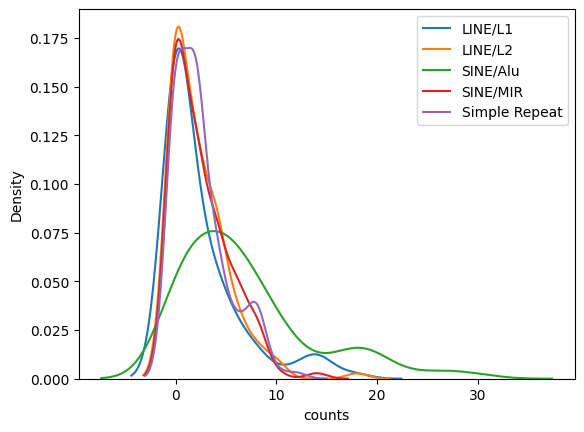

In [5]:
sns.kdeplot(data=result, x=result["LINE/L1_counts"], label="LINE/L1")
sns.kdeplot(data=result, x=result["LINE/L2_counts"], label="LINE/L2")
sns.kdeplot(data=result, x=result["SINE/Alu_counts"], label="SINE/Alu")
sns.kdeplot(data=result, x=result["SINE/MIR_counts"], label="SINE/MIR")
sns.kdeplot(data=result, x=result["Simple_repeat_counts"], label="Simple Repeat")
plt.legend()
plt.xlabel("counts")
plt.show();

In [6]:
# Separate 'counts' columns and other columns
counts_columns = [col for col in result.columns if 'counts' in col]
other_columns = [col for col in result.columns if 'counts' not in col]
counts_columns

['LINE/L1_counts',
 'LINE/L2_counts',
 'SINE/Alu_counts',
 'SINE/MIR_counts',
 'Simple_repeat_counts']

In [7]:
cats_df = result[other_columns].copy()
num_df = result[counts_columns].copy()

# Apply Binary Encoder to other columns
be = BinaryEncoder()
be_df = pd.DataFrame()

for i in cats_df:
    cats_df[i] = cats_df[i].astype(str)
    cat_transf = be.fit_transform(cats_df[i].values.reshape(-1, 1))
    be_df = pd.concat([be_df, cat_transf], axis=1)

# Apply QuantileTransformer to 'counts' columns
qt = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')

line_l1_transf = qt.fit_transform(num_df['LINE/L1_counts'].values.reshape(-1, 1))
line_l2_transf = qt.fit_transform(num_df['LINE/L2_counts'].values.reshape(-1, 1))
sine_alu_transf = qt.fit_transform(num_df['SINE/Alu_counts'].values.reshape(-1, 1))
sine_mir_transf = qt.fit_transform(num_df['SINE/MIR_counts'].values.reshape(-1, 1))
simple_rep_transf = qt.fit_transform(num_df['Simple_repeat_counts'].values.reshape(-1, 1))

In [8]:
umap_df = be_df.copy()
umap_df["line_l1"] = line_l1_transf
umap_df["line_l2"] = line_l2_transf
umap_df["sine_alu"] = sine_alu_transf
umap_df["sine_mir"] = sine_mir_transf
umap_df["simple_rep"] = simple_rep_transf
umap_df

,0_0,0_1,0_2,0_3,0_4,0_5,0_0,0_1,0_2,0_3,...,0_3,0_0,0_1,0_0,0_1,line_l1,line_l2,sine_alu,sine_mir,simple_rep
0,0,0,0,0,0,1,0,0,0,0,...,1,0,1,0,1,5.199338,-5.199338,1.882798,-5.199338,-5.199338
1,0,0,0,0,1,0,0,0,0,0,...,1,0,1,0,1,1.335178,-5.199338,0.152506,-5.199338,-5.199338
2,0,0,0,0,1,1,0,0,0,0,...,1,0,1,0,1,0.335333,-5.199338,-0.714776,0.635270,-5.199338
3,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,1,-5.199338,0.139710,-5.199338,-5.199338,-5.199338
4,0,0,0,1,0,1,0,0,0,1,...,0,0,1,0,1,0.764710,0.139710,-0.714776,-5.199338,1.593219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,-5.199338,-5.199338,-5.199338,-5.199338,1.593219
132,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,1,-5.199338,0.747859,-0.269066,1.120205,0.063341
133,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,1,-5.199338,-5.199338,-0.269066,0.635270,-5.199338
134,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,1,-5.199338,0.139710,-0.714776,1.690622,-5.199338


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [25:33<00:00,  3.07s/trial, best loss: -0.24678022259973625]
Done!
Saved models in ./models/trained_models
Best parameters found:  {'min_cluster_size': 3.0, 'min_samples': 2.0, 'n_neighbors': 13.0}
Best silhouette score:  0.24678022259973625


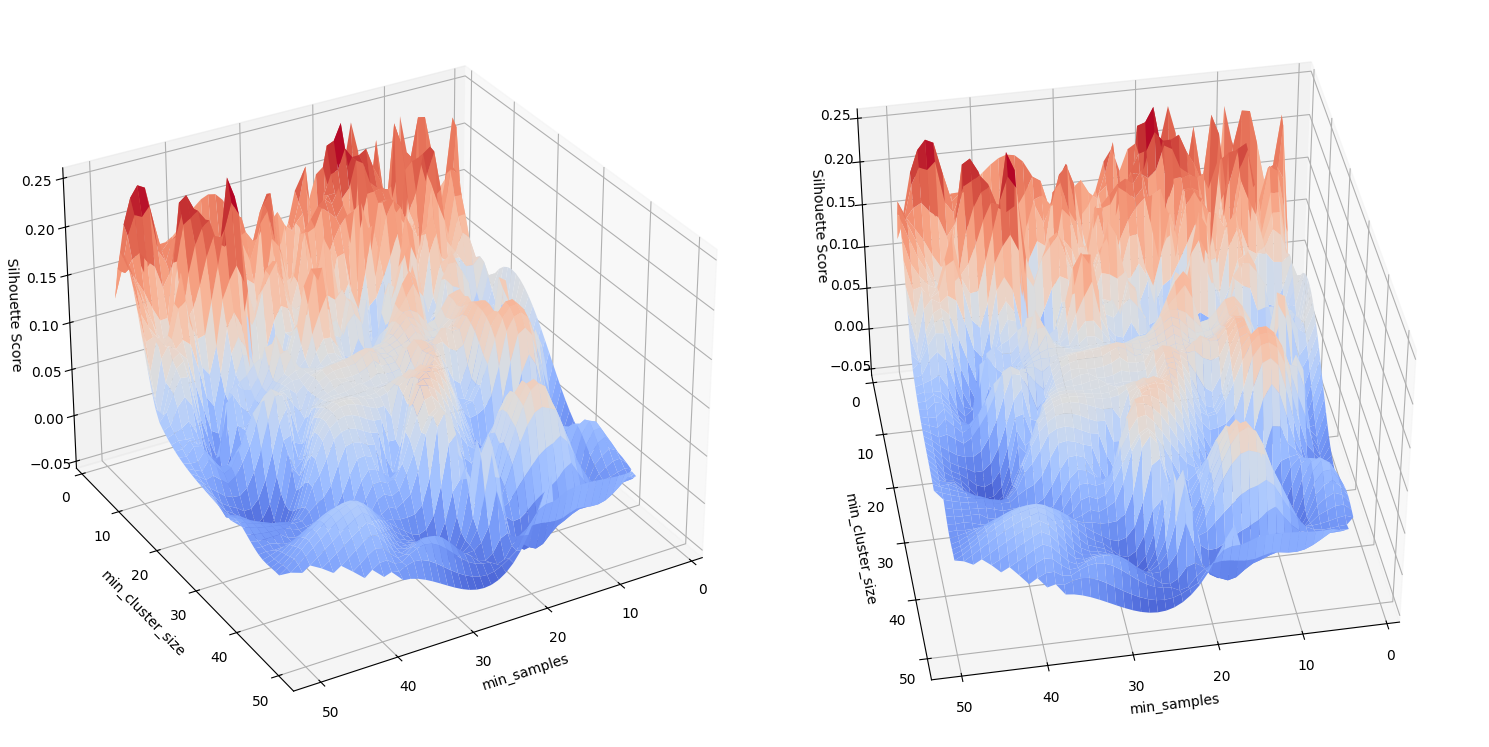

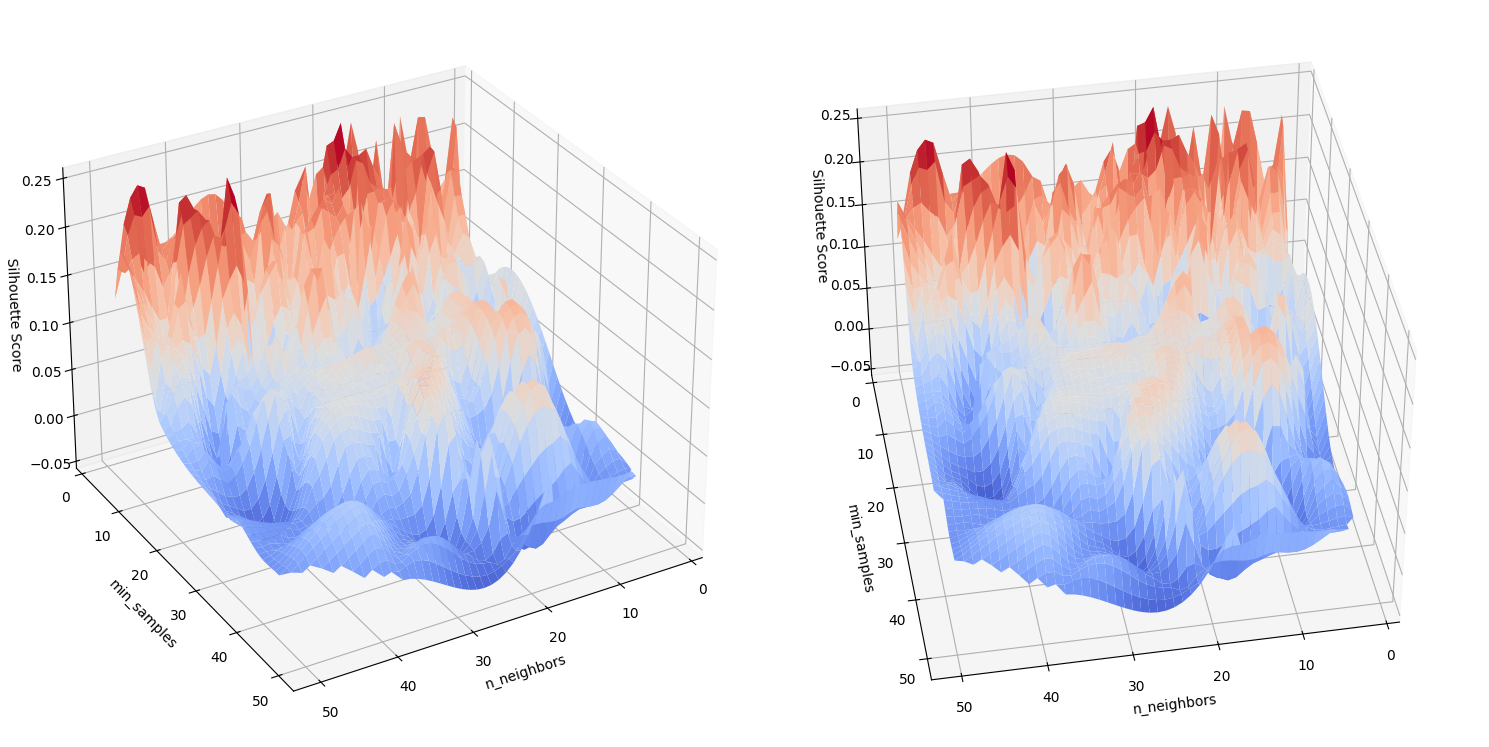

In [9]:
optimizer = UMAPHDBSCANOptimizer(umap_df)
best_params, best_score, results = optimizer.run_optimization(max_evals=500)

pipeline_name = "wide_df"
plot_hypersurface(results, figname=pipeline_name)
embedding, labels = optimizer.save_models(pipeline_name)
print("Best parameters found: ", best_params)
print("Best silhouette score: ", best_score)

result["labels"] = labels
result = result.reset_index()
df_to_dict = result[["gene", "labels"]].copy()
gene_label_dict = df_to_dict.set_index('gene')['labels'].to_dict()
df['mapped_label'] = df['gene'].map(gene_label_dict)
df.drop(["kind_num"], axis=1, inplace=True)
df.to_csv(f"./data/processed/{pipeline_name}.csv", index=False)

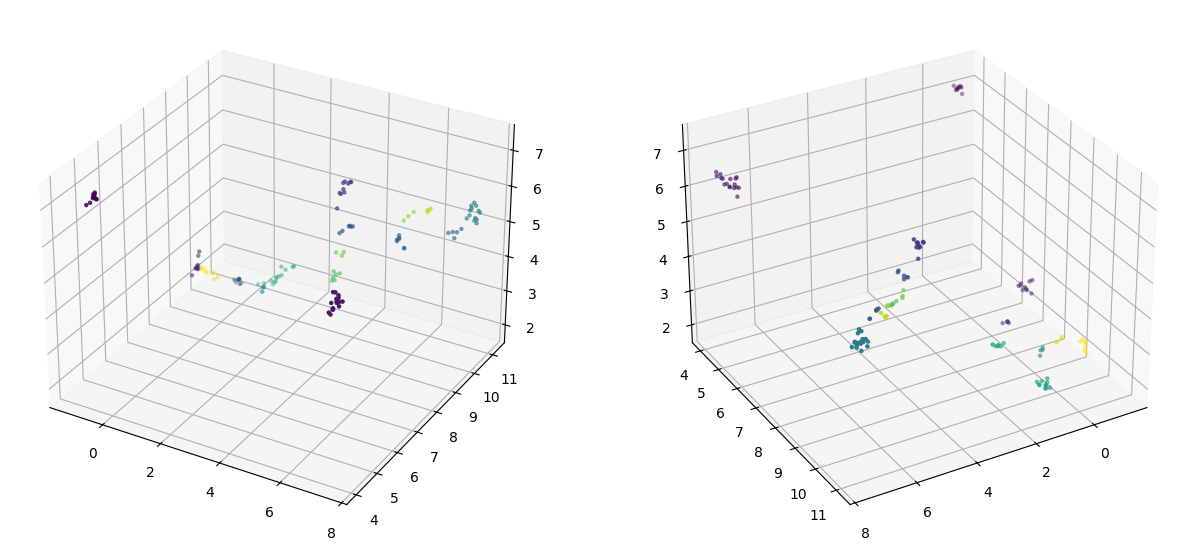

In [10]:
plot_embeddings_labeled(embedding, labels, filename=pipeline_name)

In [11]:
df

,gene,kind,position,counts,mapped_label
0,KIF1B,SINE/Alu,129,2,10
1,KIF1B,SINE/Alu,294,4,10
2,KIF1B,SINE/Alu,190,2,10
3,KIF1B,SINE/Alu,288,2,10
4,KIF1B,Simple_repeat,31,2,10
...,...,...,...,...,...
1100,GPC3,SINE/Alu,167,2,0
1101,GPC3,SINE/Alu,265,2,0
1102,GPC3,SINE/MIR,70,2,0
1103,GPC3,SINE/Alu,295,2,0


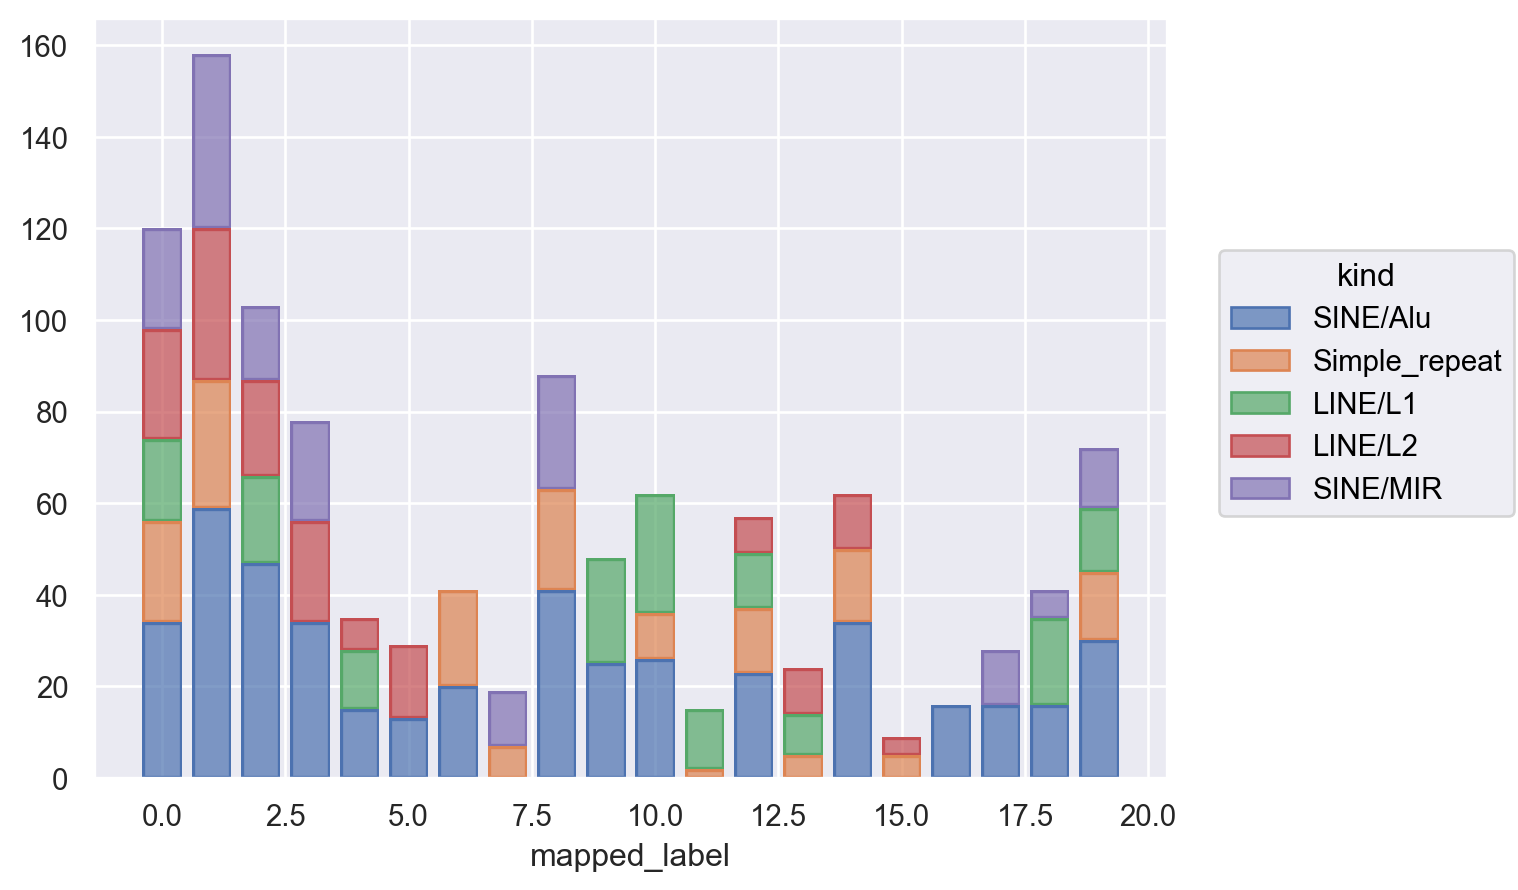

In [12]:
so.Plot(df, x="mapped_label", color="kind").add(
    so.Bar(), 
    so.Count(), 
    so.Stack())